In [1]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib
import scipy.optimize as opt
import scipy.signal as sig

In [2]:
base_path = "/Volumes/DATA/"
sphere_data = ["20230927/1",
               "20230927/2",
                "20230927/3",
                "20230927/4",
                "20230927/5",
                "20230927/6",
                "20230927/7",
                "20230927/8"]
file_label= '20230927'
remake_files = False

In [3]:
## make a list of all the calibration files and sort by impulse size
data_list = []
for curr_path in sphere_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5")))
    for file in curr_file_list:
        data_list.append(file)

Drive frequency is: 111.08 Hz


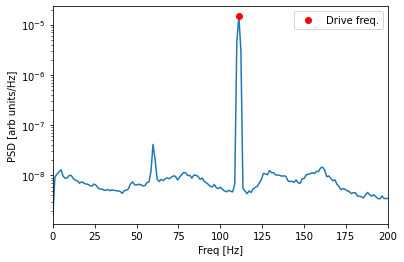

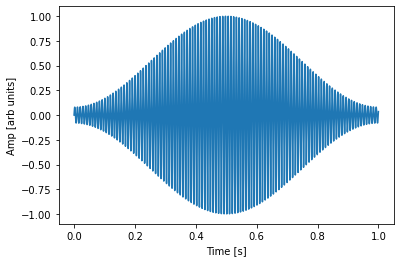

In [4]:
## make a template for the charge measurement
importlib.reload(bu)
dat, attr, _ = bu.get_data(data_list[0])
drive_template, drive_freq = bu.correlation_template_cw(dat, attr, length=1, make_plots=True)

In [5]:
importlib.reload(bu)

if(remake_files):
    charge_vec = []
    corr_vec = []
    for i,f in enumerate(data_list):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        fname = "corr_%d.png"%i
        #corr_val, curr_corr_vec = bu.simple_correlation_with_drive(cdat, attr, drive_freq, bw=1, decstages=50)
        curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=2**16)
        corr_vec = np.hstack((corr_vec, curr_corr_vec))
        corr_val = np.median(curr_corr_vec)

        time = attr["Time"]

        charge_vec.append([time, corr_val])
    charge_vec = np.array(charge_vec)
    np.save("charge_steps_%s.npy"%file_label, charge_vec)
    np.save("charge_steps_vec_%s.npy"%file_label, corr_vec)
else:
    charge_vec = np.load("charge_steps_%s.npy"%file_label)
    corr_vec = np.load("charge_steps_vec_%s.npy"%file_label)

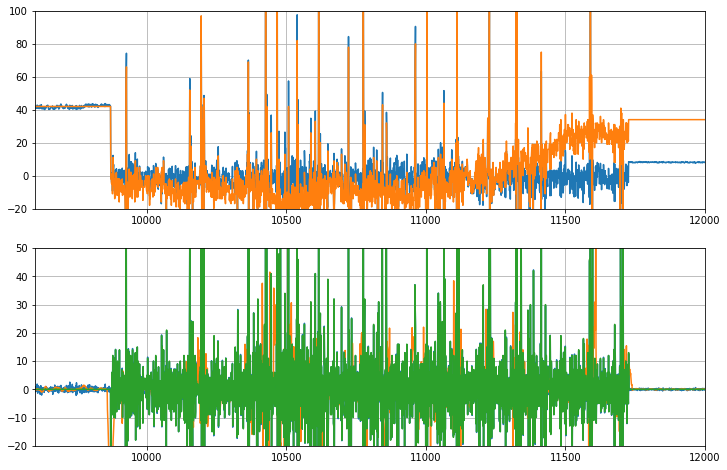

In [237]:
cal_fac = 0.072
recal = np.ones_like(corr_vec[1:])
recal[1500:7839] = 0.95


xmin, xmax = 9600, 12000 #len(corr_vec)
ymin, ymax = -20, 100 #500
init_charge = -1

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(corr_vec[1:]/cal_fac*recal, '-')
sfac = len(corr_vec)/len(charge_vec[:,1])
xvec = np.arange(len(charge_vec[:,1]))*sfac
#plt.plot(xvec, charge_vec[:,1]/cal_fac, 'o')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)

plt.subplot(2,1,2)
dv = np.diff(corr_vec/cal_fac)
plt.plot(dv)
b,a = sig.butter(3,0.3)
dv2 = sig.filtfilt(b,a,dv)
dv_chopped = np.round(dv)
bpts = (np.abs(dv) < 2) | (np.abs(dv) < 0.07*corr_vec[:-1]/cal_fac)
dv_chopped[bpts] = 0
N=25
dv2 = np.convolve(dv, sig.gaussian(N,N/4), mode='same')
plt.plot(dv2)
## fix up missed steps
dv_chopped[90] = -1
dv_chopped[226] = 1
dv_chopped[365] = 7
dv_chopped[452] = 25
dv_chopped[586] = 8
dv_chopped[788] = 8
dv_chopped[1121] = 15
dv_chopped[1208] = 2
dv_chopped[1209] = 8
dv_chopped[1381] = 8
dv_chopped[1470] = -9
dv_chopped[1658] = 2
dv_chopped[1956] = 0
dv_chopped[2000:2470] = 0
dv_chopped[2490:3400] = 0
dv_chopped[2145] = 8
dv_chopped[3072] = 15
dv_chopped[3199] = 41
dv_chopped[3258] = 8
dv_chopped[3353] = 27
dv_chopped[3400:3800] = 0
dv_chopped[3538] = 11
dv_chopped[3887] = 4
dv_chopped[4000:5000] = 0
dv_chopped[4085] = 18
dv_chopped[4646] = 22
dv_chopped[4952] = 29
dv_chopped[5011] = 8
dv_chopped[5170] = 15
dv_chopped[5842] = 12
dv_chopped[5944] = 20
dv_chopped[6273] = 59
dv_chopped[6570] = 15
dv_chopped[7200:7800] = 0
dv_chopped[7460] = 8
dv_chopped[7839] = -424
dv_chopped[8792] = 9
dv_chopped[8846] = 4
dv_chopped[9181] = 1

plt.plot(dv_chopped)
plt.xlim(xmin, xmax)
plt.ylim(-20,50)
plt.grid(True)

running_charge = np.cumsum(dv_chopped) + init_charge
plt.subplot(2,1,1)
plt.plot(running_charge, '-')

In [241]:
idx=10000
print(data_list[int(idx/16)])

/Volumes/DATA/20230927/5/LPmbar_xyzcool_8.h5


16.0
16.0


(100.0, 120.0)

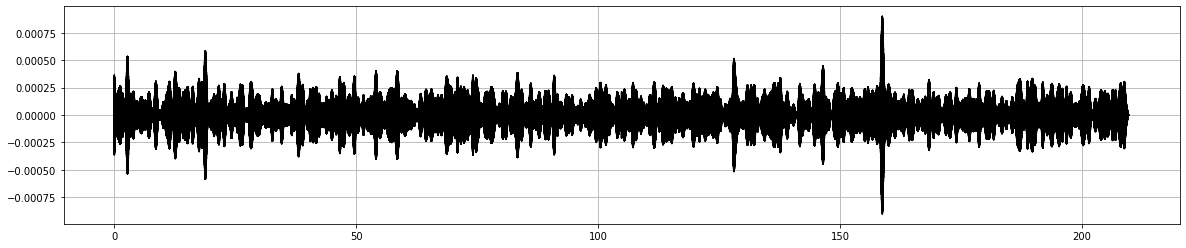

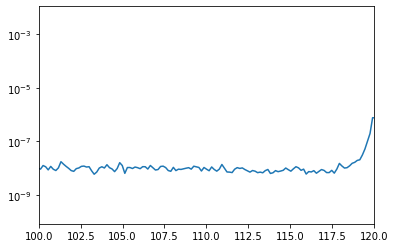

In [243]:
#cdat, attr, fhandle = bu.get_data(data_list[int(1210/16)])
idx=10000
nfiles = 2
plt.figure(figsize=(20,4))
for nf in range(nfiles):
    cdat, attr, fhandle = bu.get_data(data_list[int(idx/16)+nf])  ## correlated decays 20 s apart?
    #fn = np.array([104, 118])/5000
    fn = np.array([110, 112])/5000
    b,a = sig.butter(3, fn, btype='bandpass')
    fdat = sig.filtfilt(b,a,cdat[:,0])
    print(len(fdat)/2**16)

    tvec = np.arange(0, len(fdat))/1e4 + nf*(len(fdat)-1)/1e4


    plt.plot(tvec,fdat, 'k')
    plt.grid(True)
    #plt.xlim(60,65)
    #plt.ylim(0.06, 0.10)

plt.figure()
f,p = sig.welch(cdat[:,0], fs=1e4,nperseg=2**16)
plt.semilogy(f,p)
plt.xlim(100,120)